In [1]:
### Open 
import math
import glob, os
import pyarrow as pa
import pyarrow.csv as csv
import pyarrow.compute as pc
import numpy as np
import pandas as pd
from datetime import timedelta
import math
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute the great-circle distance (in nautical miles) between two arrays of lat/lon coordinates.
    Uses the haversine formula.
    """
    R = 3440.065  # Earth radius in nautical miles
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c
    
data_path = "./data/filtered/"  # adjust as needed
all_files = glob.glob(os.path.join(data_path, "*.csv"))
tables = []

# Note: we specify that the "# Timestamp" column should be parsed as a timestamp.
for file in all_files:
    # Adjust the convert_options as needed; here we assume timestamps are in milliseconds
    table = csv.read_csv(
        file,
        convert_options=csv.ConvertOptions(
            column_types={"# Timestamp": pa.timestamp("ms")},
            timestamp_parsers=["%d/%m/%Y %H:%M:%S"]  # This matches "25/01/2025 00:00:00"
        )
    )
    tables.append(table)

combined = pa.concat_tables(tables)
print("Combined shape:", combined.num_rows)

Combined shape: 9627649


In [2]:
# Print out the list of columns and basic info
print("Columns in the combined table:", combined.column_names)
print("Total number of rows:", combined.num_rows)

# For timestamp, check the overall range:
min_timestamp = pc.min(combined.column("# Timestamp"))
max_timestamp = pc.max(combined.column("# Timestamp"))
print("Time range:", min_timestamp.as_py(), "to", max_timestamp.as_py())


Columns in the combined table: ['# Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Total number of rows: 9627649
Time range: 2025-01-23 00:00:00 to 2025-01-30 23:59:58


In [3]:
# Example: Check for nulls in a key column (assuming 'lat' and 'lon' exist)
null_lat_count = pc.sum(pc.is_null(combined.column("Latitude")))
null_lon_count = pc.sum(pc.is_null(combined.column("Longitude")))
print("Null count - lat:", null_lat_count.as_py(), "lon:", null_lon_count.as_py())


Null count - lat: 0 lon: 0


In [4]:
lat_min = pc.min(combined.column("Latitude")).as_py()
lat_max = pc.max(combined.column("Latitude")).as_py()
lon_min = pc.min(combined.column("Longitude")).as_py()
lon_max = pc.max(combined.column("Longitude")).as_py()

print(f"Latitude: {lat_min} to {lat_max}")
print(f"Longitude: {lon_min} to {lon_max}")


Latitude: 54.018333 to 55.943392
Longitude: 12.395133 to 16.296863


In [5]:
df = combined.to_pandas()

# Suppose df is your DataFrame already loaded with ~70 million rows
# List of columns to forward fill
cols_to_fill = [
    "IMO", "Callsign", "Name", "Ship type", "Cargo type",
    "Width", "Length", "Type of position fixing device", "Draught",
    "Destination", "ETA", "A", "B", "C", "D"
]

# Define string markers that represent missing values.
missing_markers = ["", "Unknown", "Undefined"]

print("Step 1/4: Replacing missing markers with np.nan...")
# Replace markers in all target columns.
df[cols_to_fill] = df[cols_to_fill].replace(missing_markers, np.nan)
print("Missing marker replacement complete.\n")

print("Step 2/4: Performing forward fill (ffill) grouped by MMSI...")
# Forward fill within each vessel (grouped by MMSI).
df[cols_to_fill] = df.groupby("MMSI", group_keys=False)[cols_to_fill].ffill()
print("Forward fill complete.\n")

print("Step 3/4: Performing backward fill (bfill) grouped by MMSI for any remaining missing values...")
# Backward fill within each vessel to catch missing values that weren't filled by ffill.
df[cols_to_fill] = df.groupby("MMSI", group_keys=False)[cols_to_fill].bfill()
print("Backward fill complete.\n")

print("Step 4/4: All specified ship-related columns have been forward and backward filled on a per-vessel (MMSI) basis.")



Step 1/4: Replacing missing markers with np.nan...
Missing marker replacement complete.

Step 2/4: Performing forward fill (ffill) grouped by MMSI...
Forward fill complete.

Step 3/4: Performing backward fill (bfill) grouped by MMSI for any remaining missing values...
Backward fill complete.

Step 4/4: All specified ship-related columns have been forward and backward filled on a per-vessel (MMSI) basis.


In [6]:
############################################
# 3. Filter Out Unwanted Mobile Types
############################################
df.rename(columns={'# Timestamp': 'Timestamp'}, inplace=True)


exclude_types = ["AtoN", "Base Station"]  # We only keep Class A (and maybe Class B)
df = df[~df["Type of mobile"].isin(exclude_types)].copy()
print("After filtering Type of mobile:", df.shape)



After filtering Type of mobile: (9480800, 26)


In [7]:
df.head()

,Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,...,Length,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D
0,2025-01-26,Class A,245241000,55.398643,14.711777,Under way using engine,0.0,9.6,57.7,60.0,...,95.0,GPS,4.3,SODERTALJE,2025-01-27 04:00:00,AIS,85.0,10.0,3.0,11.0
1,2025-01-26,Class A,245241000,55.398643,14.711777,Under way using engine,0.0,9.6,57.7,60.0,...,95.0,GPS,4.3,SODERTALJE,2025-01-27 04:00:00,AIS,85.0,10.0,3.0,11.0
2,2025-01-26,Class A,256883000,54.743528,16.130240,Under way using engine,0.0,13.4,82.7,84.0,...,205.0,GPS,7.3,PLGDN,2025-01-26 11:00:00,AIS,18.0,187.0,15.0,15.0
4,2025-01-26,Class A,636020259,55.053283,14.032850,Under way using engine,0.0,10.6,255.0,255.0,...,177.0,GPS,9.6,EG PSD,2025-02-09 02:00:00,AIS,154.0,23.0,20.0,9.0
5,2025-01-26,Class A,215662000,55.781642,15.883830,Under way using engine,0.0,12.8,60.7,60.0,...,190.0,GPS,6.9,FI KTK,2025-01-27 22:00:00,AIS,163.0,27.0,21.0,11.0


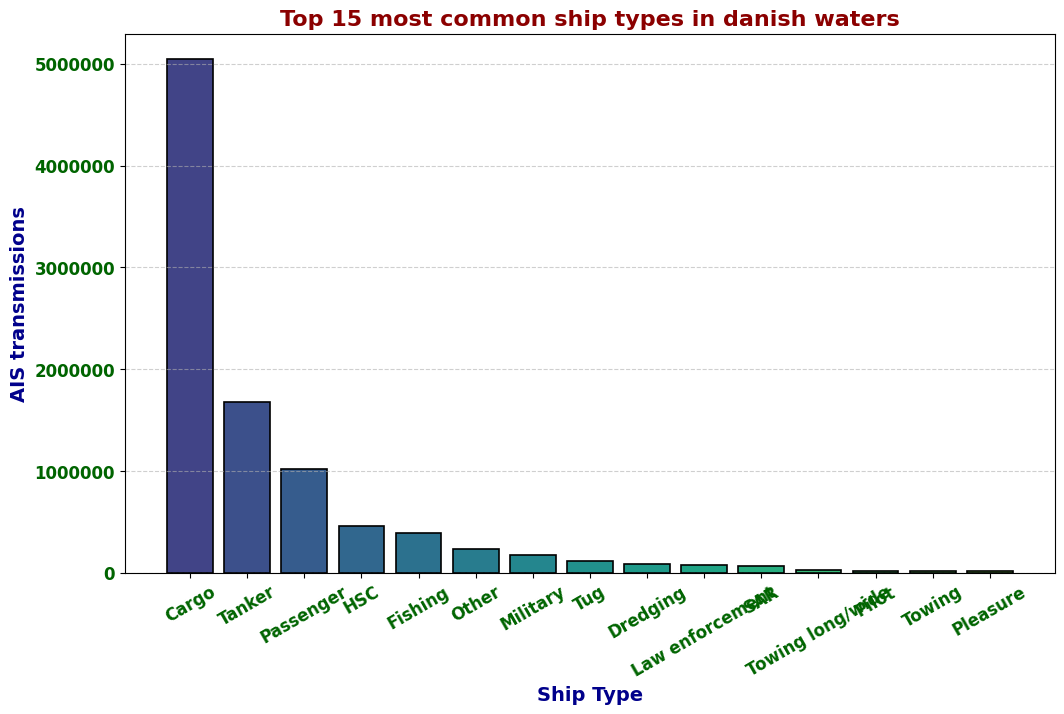

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Count occurrences of each ship type
ship_counts = df["Ship type"].value_counts()


top_ship_counts = ship_counts.nlargest(15)

# Define a cool color palette
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_ship_counts)))

# Create the bar chart with improved aesthetics
plt.figure(figsize=(12, 7))
plt.bar(top_ship_counts.index, top_ship_counts.values, color=colors, edgecolor="black", linewidth=1.2)

# Improve aesthetics of labels and ticks
plt.xlabel("Ship Type", fontsize=14, fontweight='bold', color="darkblue")
plt.ylabel("AIS transmissions", fontsize=14, fontweight='bold', color="darkblue")
plt.title("Top 15 most common ship types in danish waters", fontsize=16, fontweight='bold', color="darkred")

# Ensure x-axis labels are readable
plt.xticks(rotation=30, fontsize=12, fontweight='bold', color="darkgreen")
plt.yticks(fontsize=12, fontweight='bold', color="darkgreen")

# Format y-axis to show full numbers (no scientific notation)
plt.ticklabel_format(style='plain', axis='y')

# Add a subtle grid
plt.grid(axis="y", linestyle="--", alpha=0.6)
# Save the plot as an image
plt.savefig("./images/1_ship_distribution.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()




<Axes: xlabel='Ship type'>

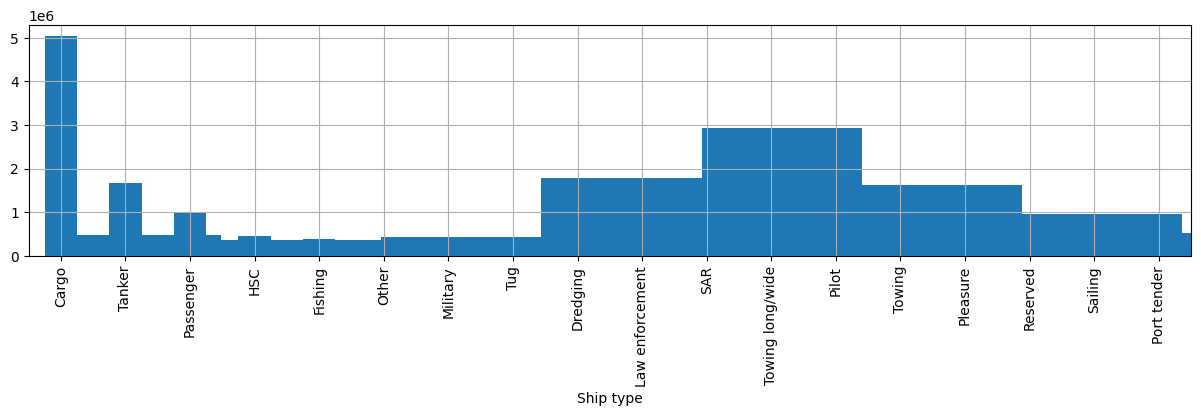

In [9]:
df["Ship type"].value_counts().plot(kind="bar", figsize=(15, 3))

df["SOG"].hist(bins=100, figsize=(15, 3))

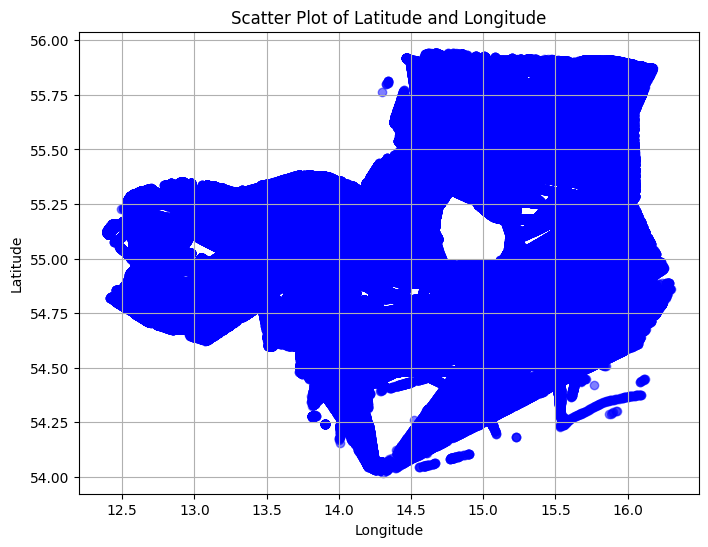

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(df["Longitude"], df["Latitude"], c='blue', marker='o', alpha=0.5)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatter Plot of Latitude and Longitude")
plt.grid(True)

plt.show()

In [11]:
missing_values = df.isnull().sum()
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': (missing_values / len(df)) * 100
})
print("Missing Values Summary:")
print(missing_summary[missing_summary['Missing Values'] > 0])


Missing Values Summary:
                                Missing Values  Percentage
ROT                                    1071116   11.297739
SOG                                       1197    0.012626
COG                                       1586    0.016729
Heading                                 142383    1.501804
IMO                                     385101    4.061904
Callsign                                 11776    0.124209
Name                                     16202    0.170893
Ship type                                71923    0.758617
Cargo type                             6303601   66.488071
Width                                    61332    0.646907
Length                                   61965    0.653584
Type of position fixing device          167375    1.765410
Draught                                 322117    3.397572
Destination                             219833    2.318718
ETA                                     367132    3.872374
A                               

In [12]:
df

,Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,...,Length,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D
0,2025-01-26 00:00:00,Class A,245241000,55.398643,14.711777,Under way using engine,0.0,9.6,57.7,60.0,...,95.0,GPS,4.3,SODERTALJE,2025-01-27 04:00:00,AIS,85.0,10.0,3.0,11.0
1,2025-01-26 00:00:00,Class A,245241000,55.398643,14.711777,Under way using engine,0.0,9.6,57.7,60.0,...,95.0,GPS,4.3,SODERTALJE,2025-01-27 04:00:00,AIS,85.0,10.0,3.0,11.0
2,2025-01-26 00:00:00,Class A,256883000,54.743528,16.130240,Under way using engine,0.0,13.4,82.7,84.0,...,205.0,GPS,7.3,PLGDN,2025-01-26 11:00:00,AIS,18.0,187.0,15.0,15.0
4,2025-01-26 00:00:00,Class A,636020259,55.053283,14.032850,Under way using engine,0.0,10.6,255.0,255.0,...,177.0,GPS,9.6,EG PSD,2025-02-09 02:00:00,AIS,154.0,23.0,20.0,9.0
5,2025-01-26 00:00:00,Class A,215662000,55.781642,15.883830,Under way using engine,0.0,12.8,60.7,60.0,...,190.0,GPS,6.9,FI KTK,2025-01-27 22:00:00,AIS,163.0,27.0,21.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9627644,2025-01-29 23:59:58,Class A,261061000,54.627823,15.627218,Under way using engine,-10.0,0.9,87.5,146.0,...,41.0,GPS,4.8,"SURVEY CPA > 0,5NM",2025-02-01 07:00:00,AIS,11.0,30.0,8.0,1.0
9627645,2025-01-29 23:59:58,Class A,255806328,55.210127,13.004408,Under way using engine,0.0,8.7,321.4,320.0,...,107.0,GPS,4.9,DKCPH,2025-01-30 04:00:00,AIS,92.0,15.0,5.0,11.0
9627646,2025-01-29 23:59:58,Class A,255806328,55.210127,13.004408,Under way using engine,0.0,8.7,321.4,320.0,...,107.0,GPS,4.9,DKCPH,2025-01-30 04:00:00,AIS,92.0,15.0,5.0,11.0
9627647,2025-01-29 23:59:58,Class A,244828000,55.386168,14.496290,Under way using engine,0.0,10.3,218.7,219.0,...,123.0,GPS,5.5,NLVLI,2025-02-01 17:00:00,AIS,112.0,11.0,10.0,4.0


In [13]:
## clean SOG 0
print("Before filtering SOG : ", df.shape)
df = df[df['SOG'] != 0.0]
print("AFter filtering SOG : ", df.shape)

## clean where latitude longitude is not inside area bounds
# Used for filtered AIS points
AIS_MIN_LON = 4.250
AIS_MIN_LAT = 53.6
AIS_MAX_LON = 19.5
AIS_MAX_LAT = 61.0
out_of_bounds = df[
    (df['Latitude'] < AIS_MIN_LAT) | (df['Latitude'] > AIS_MAX_LAT) |
    (df['Longitude'] < AIS_MIN_LON) | (df['Longitude'] > AIS_MAX_LON)
]
print("Number of rows outside bounds:", out_of_bounds.shape[0])
print("Before filtering LAT/LON inside DK: ", df.shape)
df = df[
    (df['Latitude'] >= AIS_MIN_LAT) & (df['Latitude'] <= AIS_MAX_LAT) &
    (df['Longitude'] >= AIS_MIN_LON) & (df['Longitude'] <= AIS_MAX_LON)
]
print("After filtering LAT/LOn inside DK: ", df.shape)



## clean where 

Before filtering SOG :  (9480800, 26)
AFter filtering SOG :  (9377040, 26)
Number of rows outside bounds: 0
Before filtering LAT/LON inside DK:  (9377040, 26)
After filtering LAT/LOn inside DK:  (9377040, 26)


In [14]:
import pyarrow as pa
import pyarrow.csv as pc  # CSV module in PyArrow

# Convert the DataFrame to an Arrow Table.
table = pa.Table.from_pandas(df)

# Write the Arrow Table to CSV.
pc.write_csv(table, './data/cleaned/1.csv')


In [15]:
#df.to_csv('./data/cleaned/1.csv', index=False)  # Set index=False to exclude the index column